# Project Vrijtap - Artificial Intelligence

**Author: Brian van den Berg**

This notebook serves as a training file to train a Neural Network on training images for use in the Raspberry Pi. The images are pre-processed minimally by making the images grayscale, but besides that, it's quite a simple Neural Network that is meant to be trained on situations where the tap can or cannot tap. The biggest reason for using a DNN, is because we wanted to make the tap stop when someone started tempering with it.

In [143]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Input

This chapter contains the import of training data to use on the model.

### Paths Locations

In [144]:
# Specify the input
dataset_folder = 'data'
image_extensions=('.jpg', '.jpeg', '.png')

# Get image paths
image_paths = []
for foldername, __, filenames in os.walk(dataset_folder):
    for filename in filenames:
        if filename.lower().endswith(image_extensions):
            image_paths.append(os.path.join(foldername, filename))

### Train/Test Split

Image Shape: (64, 64)
Class: 0


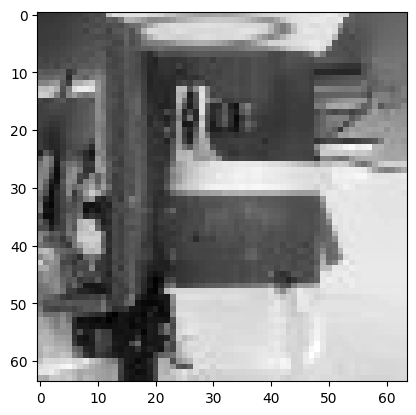

In [145]:
# Load the dataset as grayscale images
X = np.array(list(map(lambda path: cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY), image_paths)))
X = X / 255.0
Y = np.array([1 if 'cup' in path else 0 for path in image_paths])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display one selected image
image_selected = 5
print(f'Image Shape: {X_train[image_selected].shape}')
print(f'Class: {Y_train[image_selected]}')
plt.imshow(X_train[image_selected], cmap='gray')
plt.show()

## Model

The model is relatively simple. Since we're dealing with images, we're using a 2D convolutional network on the input layers. After flattening the captured features, they are then passed to a single hidden layers that contains weights trained to recognize correct tapping situations and finally, a single sigmoid activation detirmines how sure the model is of a picture having to be classified as ready or not ready.

In [146]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 31, 31, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 29, 29, 16)        2320      
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_21 (Flatten)        (None, 3136)              0         
                                                                 
 dense_42 (Dense)            (None, 64)              

## Training

In [147]:
# Train the model with less verbosity
history = model.fit(X_train, Y_train, epochs=37, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/37


17/17 - 1s - loss: 0.6374 - accuracy: 0.7615 - val_loss: 0.5081 - val_accuracy: 0.9462 - 712ms/epoch - 42ms/step
Epoch 2/37
17/17 - 0s - loss: 0.4116 - accuracy: 0.8654 - val_loss: 0.3069 - val_accuracy: 0.8923 - 257ms/epoch - 15ms/step
Epoch 3/37
17/17 - 0s - loss: 0.3239 - accuracy: 0.8538 - val_loss: 0.2346 - val_accuracy: 0.9308 - 249ms/epoch - 15ms/step
Epoch 4/37
17/17 - 0s - loss: 0.1998 - accuracy: 0.9423 - val_loss: 0.1495 - val_accuracy: 0.9692 - 251ms/epoch - 15ms/step
Epoch 5/37
17/17 - 0s - loss: 0.1331 - accuracy: 0.9654 - val_loss: 0.1089 - val_accuracy: 0.9692 - 251ms/epoch - 15ms/step
Epoch 6/37
17/17 - 0s - loss: 0.1055 - accuracy: 0.9577 - val_loss: 0.0969 - val_accuracy: 0.9692 - 248ms/epoch - 15ms/step
Epoch 7/37
17/17 - 0s - loss: 0.1219 - accuracy: 0.9519 - val_loss: 0.0835 - val_accuracy: 0.9615 - 247ms/epoch - 15ms/step
Epoch 8/37
17/17 - 0s - loss: 0.0840 - accuracy: 0.9654 - val_loss: 0.0870 - val_accuracy: 0.9615 - 247ms/epoch - 15ms/step
Epoch 9/37
17/17 - 

## Evaluation

### Train/Test History

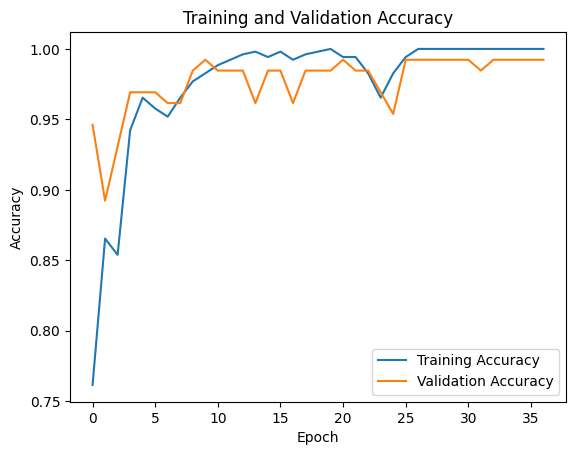

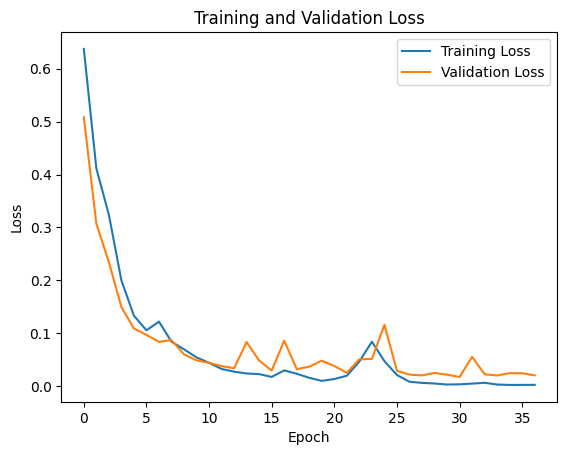

In [148]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Confusion Matrix

5/5 [==============================] - 0s 4ms/step


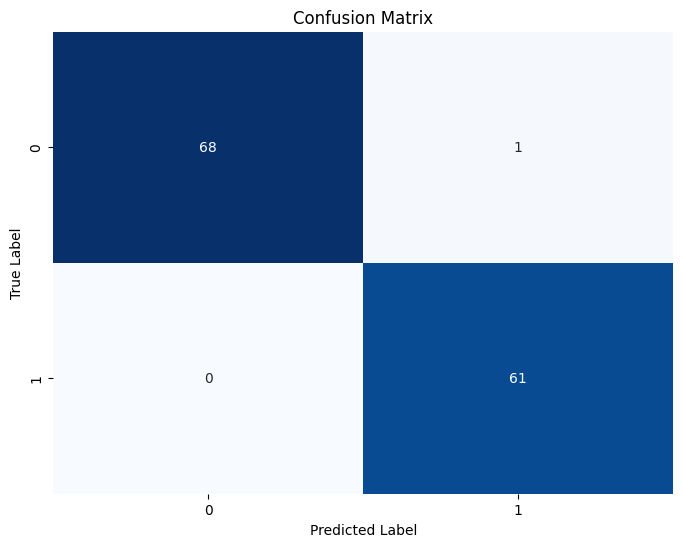

In [149]:
# Predict values for the test set
Y_pred = model.predict(X_test)

# Convert the predicted probabilities to binary class labels (0 or 1)
Y_pred_classes = (Y_pred > 0.5).astype(int)

# Confusion Matrix
conf_mat = confusion_matrix(Y_test, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [150]:
# Classification Report
classification_rep = classification_report(Y_test, Y_pred_classes)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        69
           1       0.98      1.00      0.99        61

    accuracy                           0.99       130
   macro avg       0.99      0.99      0.99       130
weighted avg       0.99      0.99      0.99       130



## Saving

In [151]:
# Save the trained model
model.save('model.h5', save_format='h5')

/home/brian-vdb/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
